# **Setup and Imports**

In [ ]:
# ✅ STEP 1: Import libraries
!pip install selfies
!pip install rdkit-pypi
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import selfies
from selfies import encoder, decoder, split_selfies, EncoderError
from sklearn.model_selection import train_test_split
from rdkit import Chem
import random

# **Load and Convert Dataset**

In [ ]:
#✅ STEP 2: Load dataset (light QM9 CSV)
df = pd.read_csv("https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm9.csv")
df = df.dropna(subset=["smiles"]).reset_index(drop=True)
smiles_list = df['smiles'].sample(10000, random_state=42).tolist()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133885 entries, 0 to 133884
Data columns (total 21 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   mol_id     133885 non-null  object 
 1   smiles     133885 non-null  object 
 2   A          133885 non-null  float64
 3   B          133885 non-null  float64
 4   C          133885 non-null  float64
 5   mu         133885 non-null  float64
 6   alpha      133885 non-null  float64
 7   homo       133885 non-null  float64
 8   lumo       133885 non-null  float64
 9   gap        133885 non-null  float64
 10  r2         133885 non-null  float64
 11  zpve       133885 non-null  float64
 12  u0         133885 non-null  float64
 13  u298       133885 non-null  float64
 14  h298       133885 non-null  float64
 15  g298       133885 non-null  float64
 16  cv         133885 non-null  float64
 17  u0_atom    133885 non-null  float64
 18  u298_atom  133885 non-null  float64
 19  h298_atom  133885 non-n

- SMILES (Simplified Molecular Input Line Entry System) string, which encodes the molecule structure in a linear string format.

- SMILES is converted into SELFIES (due to many invalid strings in SMILES , SELFIES instead is ML friendly, where all strings are valid molecules )

In [ ]:
# ✅ STEP 3: Convert SMILES to SELFIES (skip invalid ones)
selfies_list = []
for s in smiles_list:
    try:
        selfies_list.append(encoder(s)) # Converts every SMILES string into its SELFIES equivalent using the encoder
    except EncoderError:  # If a SMILES string cannot be encoded (invalid)>> skipped
        continue

# ***Tokenization and Data Loader***

---

 SMILES → SELFIES → Tokens → Indices → padding → sos  is essential for model compatibility.

In [ ]:
# ✅ STEP 4: Tokenize SELFIES
all_tokens = set() # stores unique tokens
tokenized_selfies = []# hold the list of tokenized molecules
max_len = 0

for s in selfies_list:
    tokens = list(split_selfies(s)) #Breaks the SELFIES string into a list of tokens.
    tokenized_selfies.append(tokens)
    all_tokens.update(tokens)
    max_len = max(max_len, len(tokens))
# convert from selfies format into indexed format
selfie2idx = {tok: i + 2 for i, tok in enumerate(sorted(all_tokens))} #Assign a unique integer index to each SELFIES token, 2 >> leaving space for pad and sos
selfie2idx["<PAD>"] = 0
selfie2idx["<SOS>"] = 1 # start of sequence(where molecule seq. starts)
idx2selfie = {i: s for s, i in selfie2idx.items()} # inverse, convert index back to tokens

def encode_selfie(s_tokens): #Input a tokenized SELFIES string, output : indices
    return [selfie2idx['<SOS>']] + [selfie2idx[t] for t in s_tokens] + [selfie2idx['<PAD>']] * (max_len - len(s_tokens))

def decode_selfie(indices): #Input a list of token indices , output : tokenized SELFIES string, convert selfies back to valid smile
    tokens = [idx2selfie.get(i, '') for i in indices if i > 1]
    return decoder("".join(tokens))


In [ ]:
# ✅ STEP 5: Prepare input tensor
encoded = [encode_selfie(s) for s in tokenized_selfies] # add el output of encoding(el fo2) ll padding
input_tensor = torch.tensor(encoded, dtype=torch.long)

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset # Import TensorDataset here

# Split the input tensor into training and validation sets (90/10)
train_tensor, val_tensor = train_test_split(input_tensor, test_size=0.1, random_state=42)

# Create datasets
train_dataset = TensorDataset(train_tensor)
val_dataset = TensorDataset(val_tensor)

DataLoader: to feed the model batches of training data

In [ ]:
# ✅ STEP 6: Create DataLoader
from torch.utils.data import DataLoader, TensorDataset
batch_size = 64
dataset = TensorDataset(input_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# shuffle=True ensures the training data is randomly shuffled each epoch to promote better generalization.

#**Define and Train the VAE**

In [ ]:
# ✅ STEP 7: Define the VAE model
class SELFIESVAE(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, hidden_dim=256, latent_dim=128, max_len=100):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0) #Converts each token index into a dense vector (like word embeddings)
        self.encoder_lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)#Processes input sequence and summarizes it into a hidden state
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)#Outputs the mean (μ) of the latent space
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)#Outputs the log-variance (logσ²) of the latent space
        self.decoder_input = nn.Linear(latent_dim, hidden_dim)#Maps latent vector back into a decoder hidden state
        self.decoder_lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)#Generates one token at a time from the hidden state#
        self.output_fc = nn.Linear(hidden_dim, vocab_size)#Projects decoder output to the vocabulary size (for predicting next token)
        self.max_len = max_len#	Maximum length of output sequences

    def encode(self, x):#	Maps input to latent space (mu, logvar)
        embedded = self.embedding(x)
        _, (hidden, _) = self.encoder_lstm(embedded)
        hidden = hidden[-1]
        return self.fc_mu(hidden), self.fc_logvar(hidden)

    def reparameterize(self, mu, logvar):#Samples z from latent distribution
        std = torch.exp(0.5 * logvar)
        return mu + std * torch.randn_like(std)

    def decode(self, z):#Generates output sequence from z
        batch_size = z.size(0)
        hidden = self.decoder_input(z).unsqueeze(0)
        cell = torch.zeros_like(hidden)
        inputs = torch.full((batch_size, 1), 1, dtype=torch.long).to(z.device)  # <SOS>
        outputs = []
        for _ in range(self.max_len):
            embedded = self.embedding(inputs)
            out, (hidden, cell) = self.decoder_lstm(embedded, (hidden, cell))
            logits = self.output_fc(out.squeeze(1))
            outputs.append(logits.unsqueeze(1))
            inputs = logits.argmax(dim=-1).unsqueeze(1)
        return torch.cat(outputs, dim=1)

    def forward(self, x):#Full VAE pipeline: x → z → sequence
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [ ]:
# ✅ STEP 8: Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")#Chooses GPU (if available) for faster training.
model = SELFIESVAE(vocab_size=len(selfie2idx), max_len=max_len+1).to(device)#Initializes the model using: The vocabulary size ,The sequence length (max_len+1 includes <SOS>)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# recon_logits>> Model output before softmax — predicts which token should come next.
def vae_loss(recon_logits, target, mu, logvar):#Total loss: Sum of both components.(kl divergence , recostruction)
    recon_loss = F.cross_entropy(recon_logits.view(-1, recon_logits.size(-1)), target.view(-1), ignore_index=0)
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

train_losses = []
val_losses = []

n_epochs = 20

for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for batch in dataloader:
        x = batch[0].to(device)
        optimizer.zero_grad()
        recon_logits, mu, logvar = model(x)
        loss = vae_loss(recon_logits, x, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader):.4f}")



Epoch 1, Loss: 1.8307
Epoch 2, Loss: 1.6872
Epoch 3, Loss: 1.6619
Epoch 4, Loss: 1.6372
Epoch 5, Loss: 1.6066
Epoch 6, Loss: 1.5902
Epoch 7, Loss: 1.5692
Epoch 8, Loss: 1.5262
Epoch 9, Loss: 1.4569
Epoch 10, Loss: 1.3789
Epoch 11, Loss: 1.3036
Epoch 12, Loss: 1.2503
Epoch 13, Loss: 1.1931
Epoch 14, Loss: 1.1660
Epoch 15, Loss: 1.1560
Epoch 16, Loss: 1.1009
Epoch 17, Loss: 1.0761
Epoch 18, Loss: 1.0498
Epoch 19, Loss: 1.0209
Epoch 20, Loss: 1.0655


# **Generate Molecules**

In [ ]:
# ✅ STEP 9: Sample new molecules from learned latent space
def sample_selfies(model, input_tensor, num_samples=10):
    model.eval()
    with torch.no_grad():
        mu, _ = model.encode(input_tensor[:1000].to(device))
        z = mu[torch.randint(0, mu.shape[0], (num_samples,))]
        logits = model.decode(z)
        tokens = logits.argmax(dim=-1).cpu().numpy()
        return [decode_selfie(t) for t in tokens]

 Sample and Validate Molecules
 This section uses the trained VAE to generate new molecular structures.
 `sample_selfies()` samples random latent vectors (z) from the encoder's latent space
  and decodes them into sequences of SELFIES tokens, which are converted back to SMILES strings.
 - Each generated SMILES is validated using RDKit's `MolFromSmiles()` function to ensure it represents
  a chemically valid molecule.
 - Valid molecules are collected for further analysis or property calculation.


In [ ]:
# ✅ STEP 10: Generate and print valid SMILES
generated = sample_selfies(model, input_tensor, num_samples=10)

valid_smiles = []
valid_mols = []
for i, s in enumerate(generated):
    mol = Chem.MolFromSmiles(s)
    is_valid = mol is not None
    print(f"{i+1}. {s} --> {'Valid' if is_valid else 'Invalid'}")
    if is_valid:
        valid_smiles.append(Chem.MolToSmiles(mol))
        valid_mols.append(mol)




1. O1C(C#N)CC=2CC=21 --> Valid
2. C1C(CC2)C2C=3CC=31 --> Valid
3. C=C(CCCCC)C=O --> Valid
4. COC1CC2CC3CC132 --> Valid
5. CC1CCC2C=3C2CC1=3 --> Valid
6. CC1C2C=3C(C)C2CC1=3 --> Valid
7. CC1CCC=2CCCC1=2 --> Valid
8. CCC=1CCC(C)=C=1 --> Valid
9. OC12CC1C3C=C4CC243 --> Valid
10. CCC1(C)CCC1C=O --> Valid


# **Compute Molecular Properties**

In [ ]:
# ✅ STEP 10B: Compute RDKit Properties
from rdkit.Chem import QED, Crippen

 #Are these molecules useful as drug candidates
print("Properties of Valid Molecules:")
for i, mol in enumerate(valid_mols):
    qed = QED.qed(mol)
    logp = Crippen.MolLogP(mol)
    print(f"{i+1}. QED: {qed:.3f} | logP: {logp:.2f}")


    #	0 to 5 logP desired range
    #QED desired range > 0.5

Properties of Valid Molecules:
1. QED: 0.461 | logP: 0.96
2. QED: 0.415 | logP: 2.12
3. QED: 0.314 | logP: 2.32
4. QED: 0.514 | logP: 1.43
5. QED: 0.430 | logP: 2.36
6. QED: 0.430 | logP: 2.22
7. QED: 0.433 | logP: 2.90
8. QED: 0.453 | logP: 2.66
9. QED: 0.466 | logP: 0.70
10. QED: 0.517 | logP: 2.01


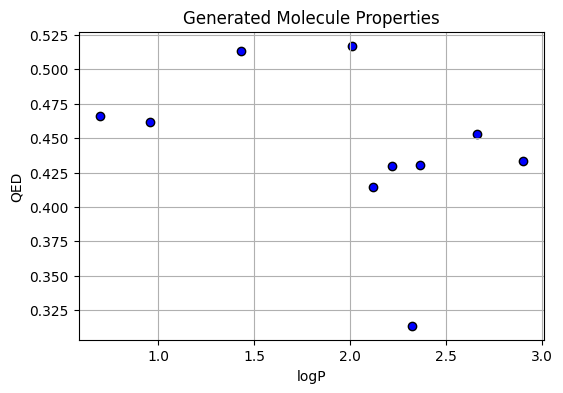

In [ ]:
import matplotlib.pyplot as plt

qed_scores = [QED.qed(mol) for mol in valid_mols]
logp_scores = [Crippen.MolLogP(mol) for mol in valid_mols]

plt.figure(figsize=(6,4))
plt.scatter(logp_scores, qed_scores, c='blue', edgecolor='k')
plt.xlabel('logP')
plt.ylabel('QED')
plt.title('Generated Molecule Properties')
plt.grid(True)
plt.show()


In [ ]:
filtered = [(Chem.MolToSmiles(m), QED.qed(m), Crippen.MolLogP(m)) for m in valid_mols if QED.qed(m) > 0.5]


# **Evaluate Molecule Quality**

In [ ]:
# ✅ STEP 11: Evaluate validity, uniqueness, and novelty
train_smiles_canon = set()
for s in selfies_list:
    try:
        smiles = decoder(s)
        m = Chem.MolFromSmiles(smiles)
        if m:
            train_smiles_canon.add(Chem.MolToSmiles(m))
    except:
        continue


unique_smiles = set(valid_smiles)
novel_smiles = unique_smiles - train_smiles_canon

validity = len(valid_smiles) / len(generated) * 100
uniqueness = len(unique_smiles) / len(valid_smiles) * 100 if valid_smiles else 0
novelty = len(novel_smiles) / len(unique_smiles) * 100 if unique_smiles else 0

print("\nEvaluation Results:")
print(f"Validity:   {validity:.2f}%") #How many generated molecules are chemically valid
print(f"Uniqueness: {uniqueness:.2f}%") #How many valid molecules are distinct
print(f"Novelty:    {novelty:.2f}%")#How many valid, unique molecules were not in the training data




Evaluation Results:
Validity:   100.00%
Uniqueness: 100.00%
Novelty:    100.00%
